In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.nn import functional as F
import math

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

In [23]:
def FMNIST_dataset():
    train_data = FashionMNIST(root='data', train=True, download=True, transform=ToTensor())
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    test_data = FashionMNIST(root='data', train=False, download=True, transform=ToTensor())
    test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
    return train_loader, test_loader


def CIFAR10_dataset():
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
    train_set = datasets.CIFAR10(root='./data', train=True,
                                download=True, transform=transform)
    test_set = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform)
    
    batch_size = 64
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    return train_loader, test_loader


def Run(dataset, model, optimizer, criterion, EPOCHS):
    if dataset == 'CIFAR-10': train_loader, test_loader = CIFAR10_dataset()
    elif dataset == 'FMNIST': train_loader, test_loader = FMNIST_dataset()
    
    train_acc_list = []
    test_acc_list = []
    train_loss_list = []
    test_loss_list = []
    for epoch in range(EPOCHS):
        # Train
        model.train()
        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data, epoch)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (output.argmax(1) == target).sum().item()
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        # Test
        model.eval()
        test_loss = 0
        test_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data, epoch)
                loss = criterion(output, target)
                test_loss += loss.item()
                test_correct += (output.argmax(1) == target).sum().item()
            test_loss /= len(test_loader.dataset)
            test_accuracy = test_correct / len(test_loader.dataset)
            test_acc_list.append(test_accuracy)
            test_loss_list.append(test_loss)
        
        # Show Result
        print(f'Epoch {epoch + 1:2d} | '
            f'Train Loss: {train_loss:.4f} | Train Accuracy: {round(train_accuracy*100, 2)} | '
            f'Test Loss: {test_loss:.4f} | Test Accuracy: {round(test_accuracy*100, 2)}')
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list


def plot(method, dataset, exp_num, train_loss_list, train_acc_list, test_loss_list, test_acc_list, save=False):
    figname = f"{method} ({dataset}) #{exp_num}.png"
    plt.figure(figsize=(10, 6), dpi=1000)
    plt.plot(train_acc_list, label='Train_acc')
    plt.plot(test_acc_list, label='Test_acc')
    plt.plot(train_loss_list, label='Train_loss')
    plt.plot(test_loss_list, label='Test_loss')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if save: plt.savefig(figname)
    plt.show()

In [24]:
# Epsilon Dropout Method
def lowdrop(x, e):
    mask = x-e
    mask = torch.ceil(mask)
    return x*mask

def highdrop(x, e):
    mask = -1 * (x-(1-e))
    mask = torch.ceil(mask)
    return x*mask

class EDrop(nn.Module):
    def __init__(self, e=0.5, switch=999999):
        super(EDrop, self).__init__()
        self.e = e
        self.switch = switch
        self.lowdrop = lowdrop
        self.highdrop = highdrop
        
    def forward(self, x, curr_epoch):
        if not self.training: 
            return x
        
        if curr_epoch < self.switch    : 
            return highdrop(x, self.e)
        elif self.switch <= curr_epoch :  
            return lowdrop(x, self.e)

In [25]:
class Net_CIFAR10(nn.Module):
    def __init__(self, epsilon, switch):
        super().__init__()
        # Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 10)

        # Materials
        self.ldrop = lowdrop
        self.hdrop = highdrop
        self.EDrop = EDrop(epsilon, switch)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x, e):
        # [64, 3, 32, 32]

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.EDrop(x, e)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.EDrop(x, e)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # x = x.view(-1, 64 * 8 * 8)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.EDrop(x, e)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [26]:
dataset = 'CIFAR-10'
CIFAR10_EPSILON = 0.2
CIFAR10_EPOCHS = 5
CIFAR10_SWITCH = 99999999

model = Net_CIFAR10(CIFAR10_EPSILON, CIFAR10_SWITCH).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [27]:
# Run (CIFAR-10)
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(dataset, model, optimizer, criterion, CIFAR10_EPOCHS)

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.0311 | Train Accuracy: 33.79 | Test Loss: 1.0434 | Test Accuracy: 19.78
Epoch  2 | Train Loss: 0.0299 | Train Accuracy: 37.3 | Test Loss: 1.0418 | Test Accuracy: 18.18
Epoch  3 | Train Loss: 0.0294 | Train Accuracy: 38.0 | Test Loss: 1.3070 | Test Accuracy: 15.7
Epoch  4 | Train Loss: 0.0289 | Train Accuracy: 38.98 | Test Loss: 1.1254 | Test Accuracy: 18.54
Epoch  5 | Train Loss: 0.0282 | Train Accuracy: 40.69 | Test Loss: 1.8426 | Test Accuracy: 17.1


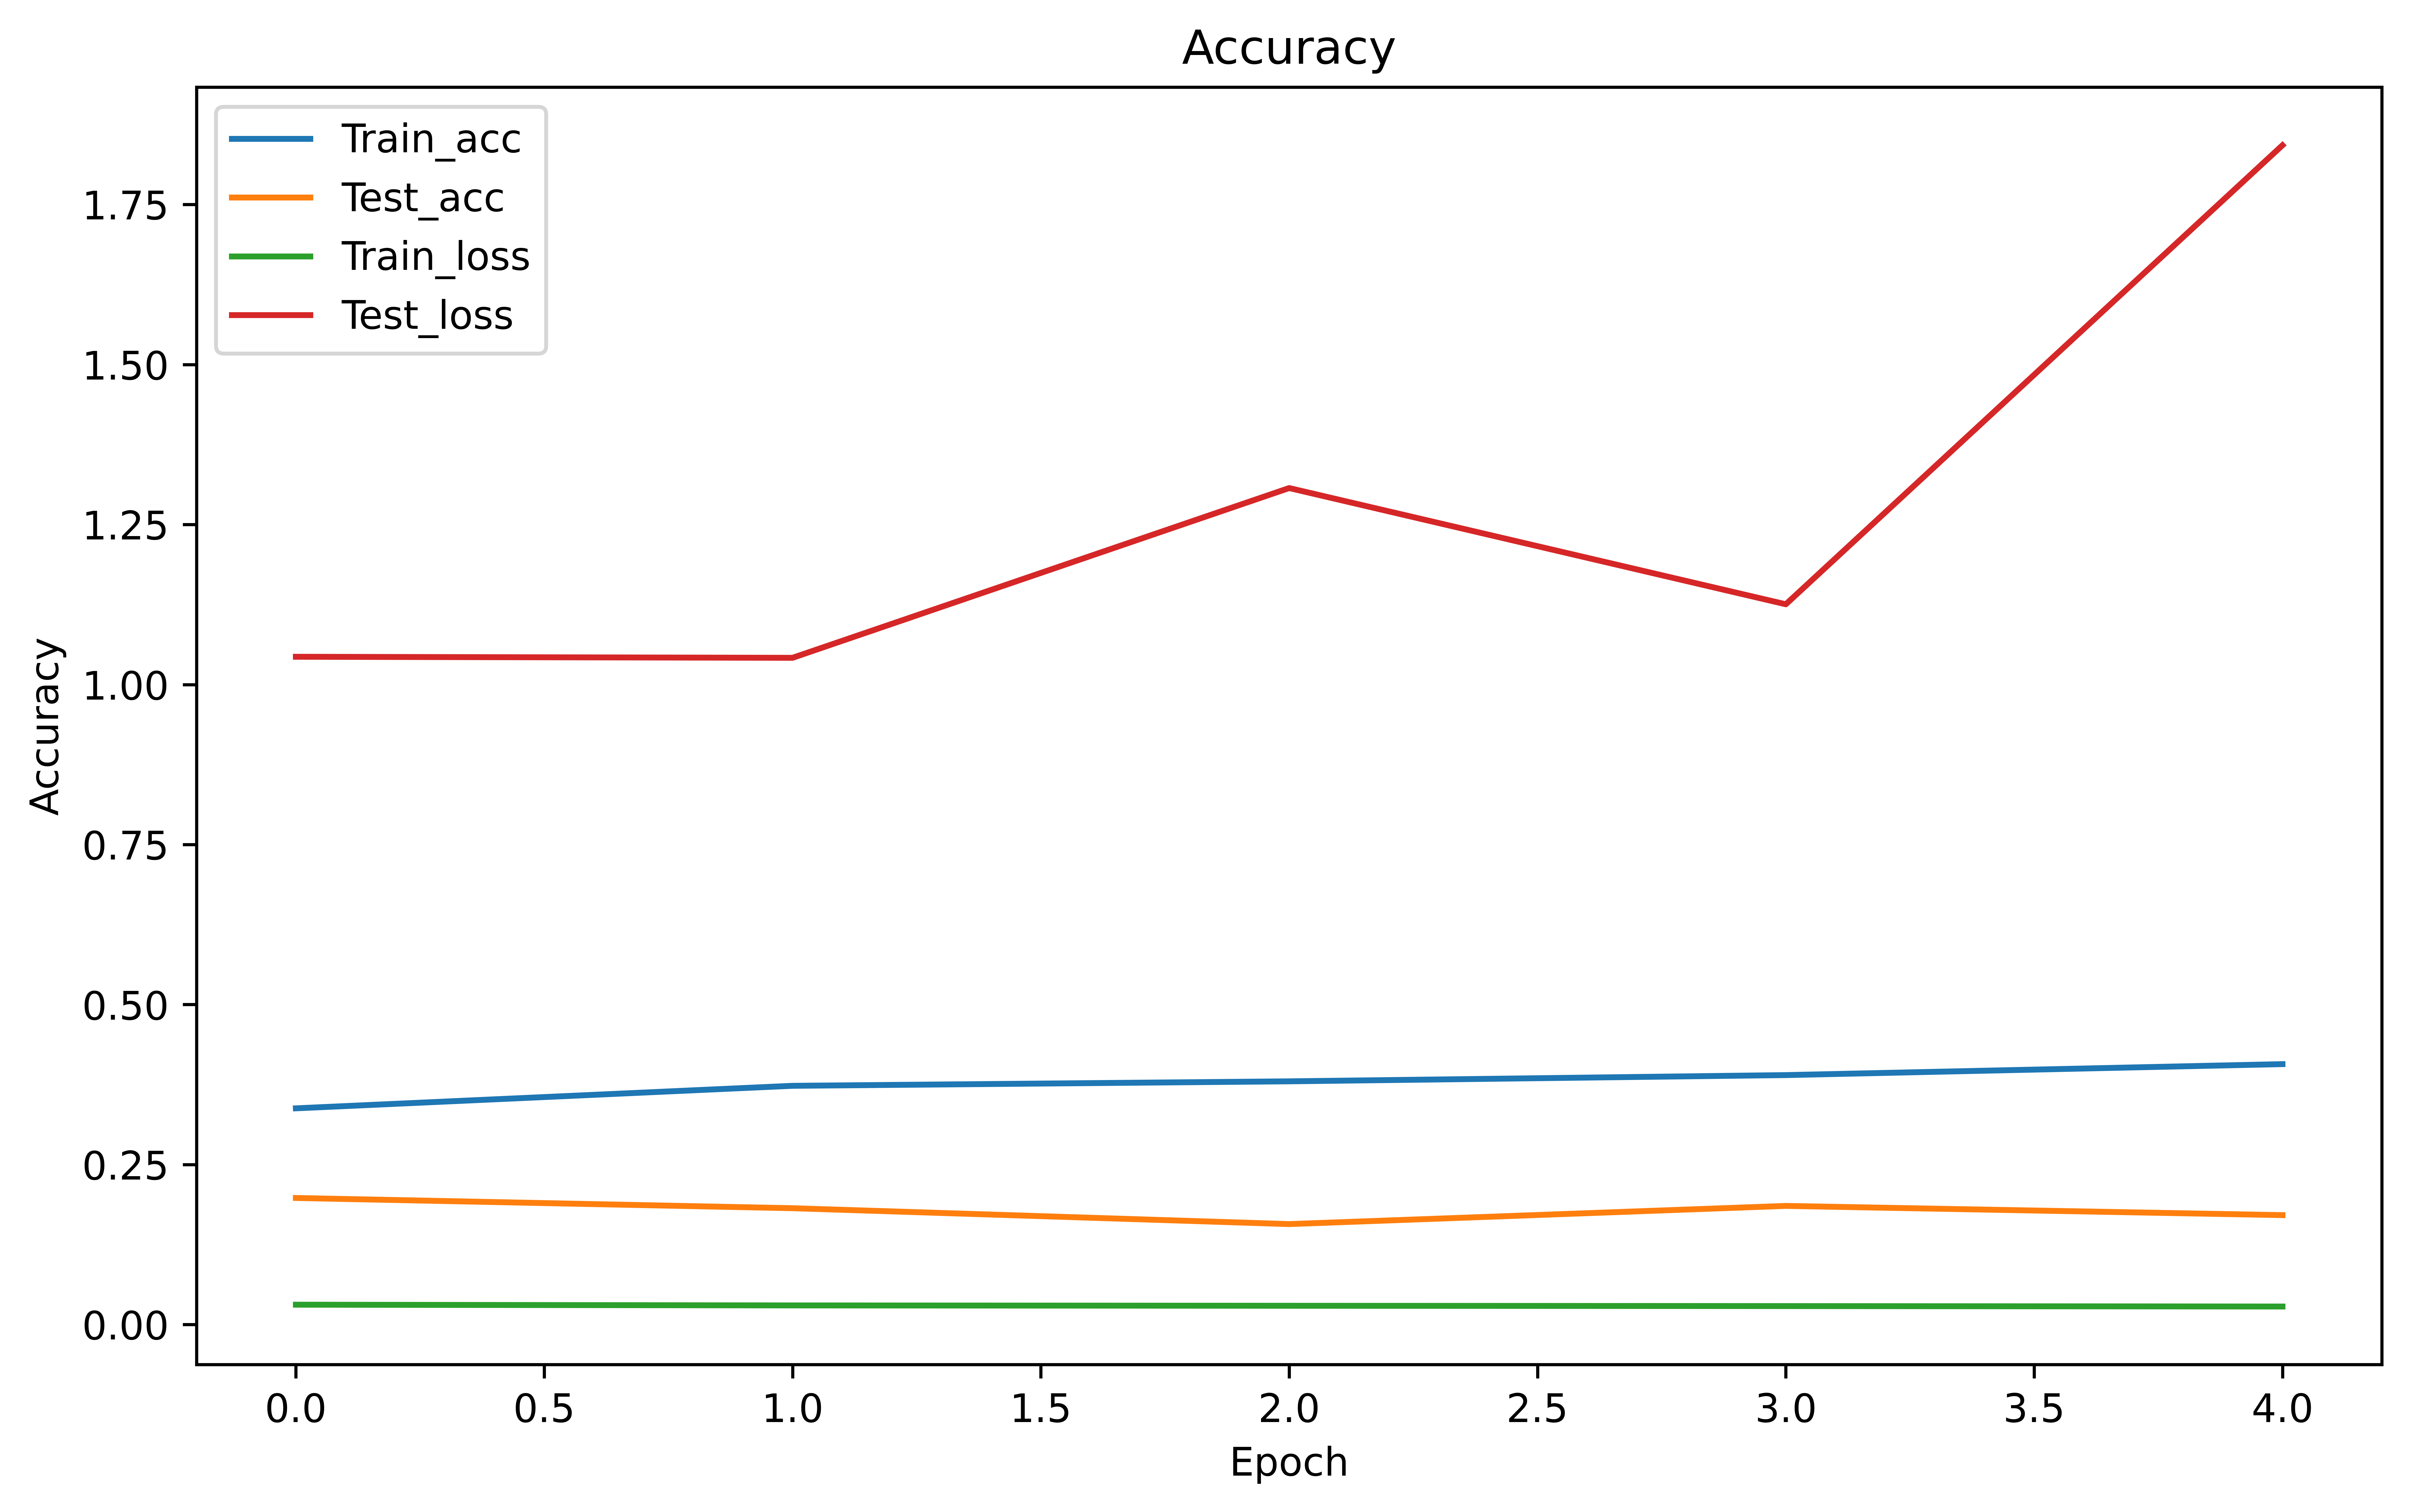

In [28]:
method = 'ED'
dataset = 'CIFAR-10'
exp_num = '1'
save = False
plot(method, dataset, exp_num, train_loss_list, train_acc_list, test_loss_list, test_acc_list, save)